In [2]:
import torch
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report
import time
from spn_3.spn import SPN
from utils import train, count_parameters, apply_lth_pruning, clean_weights, merge_weights


In [3]:
# Set the seed for PyTorch (CPU and GPU)
torch.manual_seed(42)

torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [4]:
#hyperparameters
batch_size = 64
learning_rate = 1e-2
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Get Dataset

In [5]:
# Step 1: Load the 20 Newsgroups dataset
newsgroups = fetch_20newsgroups(subset='all')

# Step 2: Pre-process the data (text vectorization using TF-IDF)
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)  # Limit to 5000 features
X = vectorizer.fit_transform(newsgroups.data).toarray()

# Step 3: Encode the labels (target classes)
le = LabelEncoder()
y = le.fit_transform(newsgroups.target)

# Step 4: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 5: Create custom Dataset for PyTorch
class NewsGroupDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Step 6: Create DataLoader for train and test sets
train_dataset = NewsGroupDataset(X_train, y_train)
test_dataset = NewsGroupDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


Minimal MLP

In [15]:
class Minimal_MLP(nn.Module):
    def __init__(self, input_size, hidden_dim, num_classes):
        super().__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_dim))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dim, num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

MLP baseline

In [16]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_dims, num_classes):
        super().__init__()
        layers = []
        prev_dim = input_size
        for hdim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hdim))
            layers.append(nn.ReLU())
            prev_dim = hdim
        layers.append(nn.Linear(prev_dim, num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [17]:
num_classes = len(le.classes_)
MLP_hidden_dims = [64, 32]
total_nodes = sum(MLP_hidden_dims)
input_size = X_train.shape[1]
num_samples = X_train.shape[0]

In [18]:
model_0 = Minimal_MLP(input_size, sum(MLP_hidden_dims), num_classes).cuda()

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optimizer = optim.Adam(model_0.parameters(), lr=learning_rate)

In [20]:
param_count_0 = count_parameters(model_0)

In [21]:
train_metrics_0, val_metrics_0 = train(model_0, train_loader, test_loader, epochs, optimizer, criterion, device=device)


Epoch: 1 Total_Time: 0.2257 Average_Time_per_batch: 0.0011 Train_Accuracy: 0.7771 Train_Loss: 0.8419 Validation_Accuracy: 0.8755 Validation_Loss: 0.4128
Epoch: 2 Total_Time: 0.1956 Average_Time_per_batch: 0.0009 Train_Accuracy: 0.9710 Train_Loss: 0.1108 Validation_Accuracy: 0.8824 Validation_Loss: 0.4102
Epoch: 3 Total_Time: 0.1955 Average_Time_per_batch: 0.0009 Train_Accuracy: 0.9948 Train_Loss: 0.0278 Validation_Accuracy: 0.8842 Validation_Loss: 0.4341
Epoch: 4 Total_Time: 0.1934 Average_Time_per_batch: 0.0009 Train_Accuracy: 0.9980 Train_Loss: 0.0134 Validation_Accuracy: 0.8852 Validation_Loss: 0.4448
Epoch: 5 Total_Time: 0.1942 Average_Time_per_batch: 0.0009 Train_Accuracy: 0.9986 Train_Loss: 0.0085 Validation_Accuracy: 0.8896 Validation_Loss: 0.4487
Epoch: 6 Total_Time: 0.1933 Average_Time_per_batch: 0.0009 Train_Accuracy: 0.9987 Train_Loss: 0.0088 Validation_Accuracy: 0.8811 Validation_Loss: 0.4832
Epoch: 7 Total_Time: 0.1928 Average_Time_per_batch: 0.0009 Train_Accuracy: 0.9986

In [22]:
model_1 = MLP(input_size, MLP_hidden_dims, num_classes).to(device)

In [23]:
optimizer = optimizer = optim.Adam(model_1.parameters(), lr=learning_rate)

In [24]:
param_count_1 = count_parameters(model_1)

In [25]:
train_metrics_1, val_metrics_1 = train(model_1, train_loader, test_loader, epochs, optimizer, criterion, device=device)


Epoch: 1 Total_Time: 0.3196 Average_Time_per_batch: 0.0015 Train_Accuracy: 0.6858 Train_Loss: 1.0430 Validation_Accuracy: 0.8414 Validation_Loss: 0.5226
Epoch: 2 Total_Time: 0.2624 Average_Time_per_batch: 0.0013 Train_Accuracy: 0.9444 Train_Loss: 0.1943 Validation_Accuracy: 0.8401 Validation_Loss: 0.5483
Epoch: 3 Total_Time: 0.2610 Average_Time_per_batch: 0.0013 Train_Accuracy: 0.9841 Train_Loss: 0.0603 Validation_Accuracy: 0.8468 Validation_Loss: 0.6503
Epoch: 4 Total_Time: 0.2612 Average_Time_per_batch: 0.0013 Train_Accuracy: 0.9945 Train_Loss: 0.0263 Validation_Accuracy: 0.8500 Validation_Loss: 0.6926
Epoch: 5 Total_Time: 0.2608 Average_Time_per_batch: 0.0013 Train_Accuracy: 0.9965 Train_Loss: 0.0160 Validation_Accuracy: 0.8544 Validation_Loss: 0.7259
Epoch: 6 Total_Time: 0.2612 Average_Time_per_batch: 0.0013 Train_Accuracy: 0.9983 Train_Loss: 0.0083 Validation_Accuracy: 0.8521 Validation_Loss: 0.7727
Epoch: 7 Total_Time: 0.2609 Average_Time_per_batch: 0.0013 Train_Accuracy: 0.9986

Minimal SPN

In [26]:
model_2 = SPN(input_size, sum(MLP_hidden_dims) + num_classes, num_classes).cuda()
optimizer = optim.Adam(model_2.parameters(), lr=learning_rate)

In [27]:
param_count_2 = model_2.count_parameters()

In [28]:
train_metrics_2, val_metrics_2 = train(model_2, train_loader, test_loader, epochs, optimizer, criterion, device=device)


Epoch: 1 Total_Time: 0.2497 Average_Time_per_batch: 0.0012 Train_Accuracy: 0.7731 Train_Loss: 0.8597 Validation_Accuracy: 0.8751 Validation_Loss: 0.4034
Epoch: 2 Total_Time: 0.2031 Average_Time_per_batch: 0.0010 Train_Accuracy: 0.9716 Train_Loss: 0.1052 Validation_Accuracy: 0.8845 Validation_Loss: 0.3944
Epoch: 3 Total_Time: 0.2025 Average_Time_per_batch: 0.0010 Train_Accuracy: 0.9949 Train_Loss: 0.0271 Validation_Accuracy: 0.8843 Validation_Loss: 0.4081
Epoch: 4 Total_Time: 0.2026 Average_Time_per_batch: 0.0010 Train_Accuracy: 0.9977 Train_Loss: 0.0127 Validation_Accuracy: 0.8888 Validation_Loss: 0.4204
Epoch: 5 Total_Time: 0.2033 Average_Time_per_batch: 0.0010 Train_Accuracy: 0.9986 Train_Loss: 0.0096 Validation_Accuracy: 0.8873 Validation_Loss: 0.4447
Epoch: 6 Total_Time: 0.2031 Average_Time_per_batch: 0.0010 Train_Accuracy: 0.9986 Train_Loss: 0.0078 Validation_Accuracy: 0.8898 Validation_Loss: 0.4515
Epoch: 7 Total_Time: 0.2032 Average_Time_per_batch: 0.0010 Train_Accuracy: 0.9989

Maximal SPN

In [29]:
model_3 = SPN(input_size, sum(MLP_hidden_dims) + num_classes, num_classes, minimal=False).cuda()
optimizer = optim.Adam(model_3.parameters(), lr=learning_rate)

In [30]:
param_count_3 = model_3.count_parameters()

In [31]:
train_metrics_3, val_metrics_3 = train(model_3, train_loader, test_loader, epochs, optimizer, criterion, device=device)


Epoch: 1 Total_Time: 10.0226 Average_Time_per_batch: 0.0484 Train_Accuracy: 0.7313 Train_Loss: 0.9082 Validation_Accuracy: 0.8518 Validation_Loss: 0.4912
Epoch: 2 Total_Time: 9.8338 Average_Time_per_batch: 0.0475 Train_Accuracy: 0.9497 Train_Loss: 0.1733 Validation_Accuracy: 0.8564 Validation_Loss: 0.4960
Epoch: 3 Total_Time: 9.7342 Average_Time_per_batch: 0.0470 Train_Accuracy: 0.9857 Train_Loss: 0.0562 Validation_Accuracy: 0.8597 Validation_Loss: 0.5561
Epoch: 4 Total_Time: 9.7354 Average_Time_per_batch: 0.0470 Train_Accuracy: 0.9921 Train_Loss: 0.0289 Validation_Accuracy: 0.8629 Validation_Loss: 0.6117
Epoch: 5 Total_Time: 9.7950 Average_Time_per_batch: 0.0473 Train_Accuracy: 0.9956 Train_Loss: 0.0178 Validation_Accuracy: 0.8520 Validation_Loss: 0.7049
Epoch: 6 Total_Time: 9.7292 Average_Time_per_batch: 0.0470 Train_Accuracy: 0.9945 Train_Loss: 0.0191 Validation_Accuracy: 0.8498 Validation_Loss: 0.7226
Epoch: 7 Total_Time: 9.7452 Average_Time_per_batch: 0.0471 Train_Accuracy: 0.996

Free Weights SPN

In [32]:
model_4 = SPN(input_size, sum(MLP_hidden_dims) + num_classes, num_classes, minimal=False, hidden_dims = MLP_hidden_dims + [num_classes]).cuda()
optimizer = optim.Adam(model_4.parameters(), lr=learning_rate)

In [33]:
param_count_4 = model_4.count_parameters()

In [34]:
train_metrics_4, val_metrics_4 = train(model_4, train_loader, test_loader, epochs, optimizer, criterion, device=device)


Epoch: 1 Total_Time: 0.4050 Average_Time_per_batch: 0.0020 Train_Accuracy: 0.7635 Train_Loss: 0.8381 Validation_Accuracy: 0.8698 Validation_Loss: 0.4361
Epoch: 2 Total_Time: 0.3236 Average_Time_per_batch: 0.0016 Train_Accuracy: 0.9611 Train_Loss: 0.1352 Validation_Accuracy: 0.8677 Validation_Loss: 0.4486
Epoch: 3 Total_Time: 0.3244 Average_Time_per_batch: 0.0016 Train_Accuracy: 0.9904 Train_Loss: 0.0389 Validation_Accuracy: 0.8734 Validation_Loss: 0.5188
Epoch: 4 Total_Time: 0.3246 Average_Time_per_batch: 0.0016 Train_Accuracy: 0.9960 Train_Loss: 0.0156 Validation_Accuracy: 0.8686 Validation_Loss: 0.5696
Epoch: 5 Total_Time: 0.3241 Average_Time_per_batch: 0.0016 Train_Accuracy: 0.9978 Train_Loss: 0.0115 Validation_Accuracy: 0.8714 Validation_Loss: 0.5889
Epoch: 6 Total_Time: 0.3243 Average_Time_per_batch: 0.0016 Train_Accuracy: 0.9990 Train_Loss: 0.0060 Validation_Accuracy: 0.8750 Validation_Loss: 0.6075
Epoch: 7 Total_Time: 0.3239 Average_Time_per_batch: 0.0016 Train_Accuracy: 0.9989

Maximal SPN with pruning

In [35]:
model_5 = SPN(input_size, sum(MLP_hidden_dims) + num_classes, num_classes, minimal=False).cuda()
optimizer = optim.Adam(model_5.parameters(), lr=learning_rate)

In [36]:
percent = 0.99
rounds = 10
pruning_epochs = 3

pruning_start = time.time()
new_weights = apply_lth_pruning(model_5, train_loader, test_loader, pruning_epochs, optimizer, criterion, percent, rounds)
pruning_time = time.time() - pruning_start

Initial Validation Phase
Epoch: 1 Total_Time: 10.0531 Average_Time_per_batch: 0.0486 Train_Accuracy: 0.7409 Train_Loss: 0.8919 Validation_Accuracy: 0.8459 Validation_Loss: 0.4992
Epoch: 2 Total_Time: 9.8330 Average_Time_per_batch: 0.0475 Train_Accuracy: 0.9449 Train_Loss: 0.1854 Validation_Accuracy: 0.8505 Validation_Loss: 0.4990
Epoch: 3 Total_Time: 9.8398 Average_Time_per_batch: 0.0475 Train_Accuracy: 0.9843 Train_Loss: 0.0562 Validation_Accuracy: 0.8484 Validation_Loss: 0.5866

Pruning Round: 1
Epoch: 1 Total_Time: 9.9186 Average_Time_per_batch: 0.0479 Train_Accuracy: 0.7586 Train_Loss: 1.0488 Validation_Accuracy: 0.8718 Validation_Loss: 0.4401
Epoch: 2 Total_Time: 9.9046 Average_Time_per_batch: 0.0478 Train_Accuracy: 0.9472 Train_Loss: 0.1846 Validation_Accuracy: 0.8746 Validation_Loss: 0.4318
Epoch: 3 Total_Time: 9.8874 Average_Time_per_batch: 0.0478 Train_Accuracy: 0.9904 Train_Loss: 0.0430 Validation_Accuracy: 0.8741 Validation_Loss: 0.5111

Pruning Round: 2
Epoch: 1 Total_Time:

In [37]:
cleaned_weights = clean_weights(new_weights, input_size)
merged_weights = merge_weights(cleaned_weights, input_size, num_classes)

Empty Blocks:  []


In [38]:
hidden_dims_pruned = [weight.shape[0] for weight in merged_weights]
print("Pruned Dimensions: ", hidden_dims_pruned)
print("Pruning Time: ", pruning_time)

Pruned Dimensions:  [92, 4, 20]
Pruning Time:  368.6067976951599


In [39]:
model_5 = SPN(input_size, sum(hidden_dims_pruned), num_classes, minimal=False, hidden_dims=hidden_dims_pruned).cuda()
optimizer = optim.Adam(model_5.parameters(), lr=learning_rate)

In [40]:
param_count_5 = model_5.count_parameters()

In [41]:
train_metrics_5, val_metrics_5 = train(model_5, train_loader, test_loader, epochs, optimizer, criterion)


Epoch: 1 Total_Time: 0.4064 Average_Time_per_batch: 0.0020 Train_Accuracy: 0.7868 Train_Loss: 0.8166 Validation_Accuracy: 0.8744 Validation_Loss: 0.4171
Epoch: 2 Total_Time: 0.3245 Average_Time_per_batch: 0.0016 Train_Accuracy: 0.9697 Train_Loss: 0.1153 Validation_Accuracy: 0.8808 Validation_Loss: 0.4131
Epoch: 3 Total_Time: 0.3247 Average_Time_per_batch: 0.0016 Train_Accuracy: 0.9936 Train_Loss: 0.0343 Validation_Accuracy: 0.8819 Validation_Loss: 0.4581
Epoch: 4 Total_Time: 0.3249 Average_Time_per_batch: 0.0016 Train_Accuracy: 0.9973 Train_Loss: 0.0149 Validation_Accuracy: 0.8783 Validation_Loss: 0.4886
Epoch: 5 Total_Time: 0.3230 Average_Time_per_batch: 0.0016 Train_Accuracy: 0.9983 Train_Loss: 0.0097 Validation_Accuracy: 0.8811 Validation_Loss: 0.5000
Epoch: 6 Total_Time: 0.3230 Average_Time_per_batch: 0.0016 Train_Accuracy: 0.9989 Train_Loss: 0.0055 Validation_Accuracy: 0.8826 Validation_Loss: 0.5121
Epoch: 7 Total_Time: 0.3241 Average_Time_per_batch: 0.0016 Train_Accuracy: 0.9989

Plot Training and Test Accuracies Across Epochs

In [42]:
import matplotlib.pyplot as plt

train_acc_0 = train_metrics_0[:, 2] / (num_samples / batch_size)
train_acc_1 = train_metrics_1[:, 2] / (num_samples / batch_size)
train_acc_2 = train_metrics_2[:, 2] / (num_samples / batch_size)
train_acc_3 = train_metrics_3[:, 2] / (num_samples / batch_size)
train_acc_4 = train_metrics_4[:, 2] / (num_samples / batch_size)
train_acc_5 = train_metrics_5[:, 2] / (num_samples / batch_size)

epochs = np.arange(1, epochs + 1)

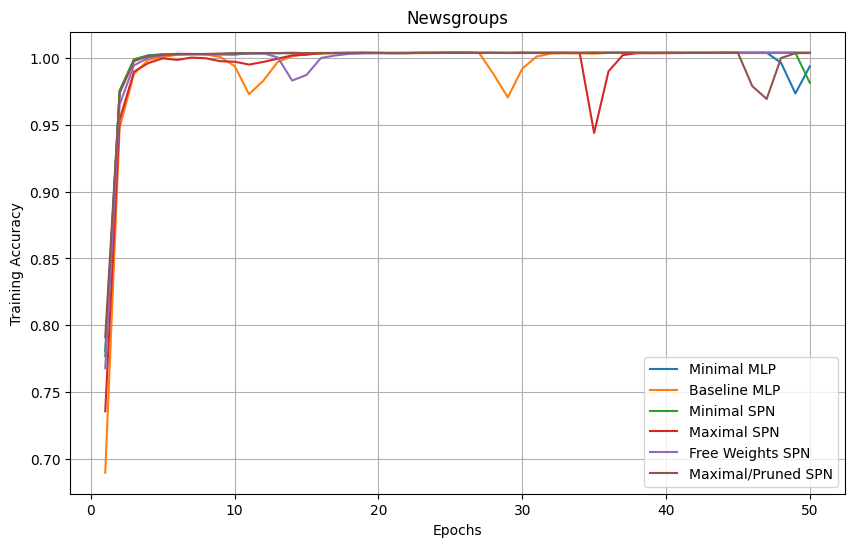

In [43]:
# Plot the training accuracy of all 5 models
plt.figure(figsize=(10, 6))

plt.plot(epochs, train_acc_0, label='Minimal MLP')
plt.plot(epochs, train_acc_1, label='Baseline MLP')
plt.plot(epochs, train_acc_2, label='Minimal SPN')
plt.plot(epochs, train_acc_3, label='Maximal SPN')
plt.plot(epochs, train_acc_4, label='Free Weights SPN')
plt.plot(epochs, train_acc_5, label='Maximal/Pruned SPN')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.title('Newsgroups')

# Adding a legend to distinguish the models
plt.legend()

# Show the plot
plt.grid(True)

#save the plot
plt.savefig('results/Newsgroups/training_accuracy_plot.png')  # Save as PNG file
plt.show()

In [44]:
test_acc_0 = val_metrics_0[:, 1]
test_acc_1 = val_metrics_1[:, 1]
test_acc_2 = val_metrics_2[:, 1]
test_acc_3 = val_metrics_3[:, 1]
test_acc_4 = val_metrics_4[:, 1]
test_acc_5 = val_metrics_5[:, 1]

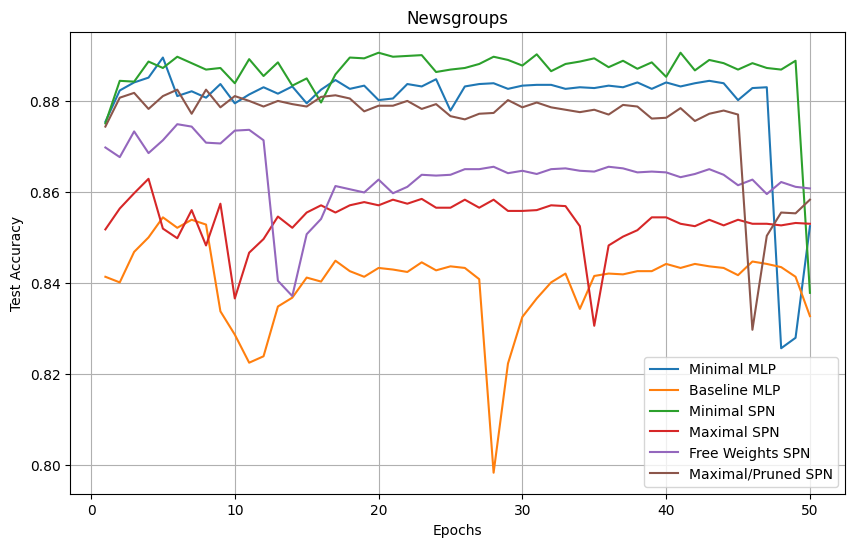

In [45]:
# Plot the training accuracy of all 5 models
plt.figure(figsize=(10, 6))

plt.plot(epochs, test_acc_0, label='Minimal MLP')
plt.plot(epochs, test_acc_1, label='Baseline MLP')
plt.plot(epochs, test_acc_2, label='Minimal SPN')
plt.plot(epochs, test_acc_3, label='Maximal SPN')
plt.plot(epochs, test_acc_4, label='Free Weights SPN')
plt.plot(epochs, test_acc_5, label='Maximal/Pruned SPN')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.title('Newsgroups')

# Adding a legend to distinguish the models
plt.legend()

# Show the plot
plt.grid(True)

#save the plot
plt.savefig('results/Newsgroups/test_accuracy_plot.png')  # Save as PNG file
plt.show()

Get efficiency of each model

In [46]:
# List of all test accuracies
test_accuracies = [test_acc_0, test_acc_1, test_acc_2, test_acc_3, test_acc_4, test_acc_5]

# Find the index of the best (maximum) accuracy for each model
best_accuracy_indices = [np.argmax(acc) + 1 for acc in test_accuracies]

In [47]:
time_to_best_acc_0 = train_metrics_0[:best_accuracy_indices[0], 0].sum()
time_to_best_acc_1 = train_metrics_1[:best_accuracy_indices[1], 0].sum()
time_to_best_acc_2 = train_metrics_2[:best_accuracy_indices[2], 0].sum()
time_to_best_acc_3 = train_metrics_3[:best_accuracy_indices[3], 0].sum()
time_to_best_acc_4 = train_metrics_4[:best_accuracy_indices[4], 0].sum()
time_to_best_acc_5 = train_metrics_5[:best_accuracy_indices[5], 0].sum()

best_test_acc_0 = test_acc_0[best_accuracy_indices[0] - 1]
best_test_acc_1 = test_acc_1[best_accuracy_indices[1] - 1]
best_test_acc_2 = test_acc_2[best_accuracy_indices[2] - 1]
best_test_acc_3 = test_acc_3[best_accuracy_indices[3] - 1]
best_test_acc_4 = test_acc_4[best_accuracy_indices[4] - 1]
best_test_acc_5 = test_acc_5[best_accuracy_indices[5] - 1]

In [48]:
summary_0 = ['Minimal MLP', param_count_0, best_test_acc_0, time_to_best_acc_0, best_test_acc_0 / time_to_best_acc_0]
summary_1 = ['Baseline MLP', param_count_1, best_test_acc_1, time_to_best_acc_1, best_test_acc_1 / time_to_best_acc_1]
summary_2 = ['Minimal SPN', param_count_2, best_test_acc_2, time_to_best_acc_2, best_test_acc_2 / time_to_best_acc_2]
summary_3 = ['Maximal SPN', param_count_3, best_test_acc_3, time_to_best_acc_3, best_test_acc_3 / time_to_best_acc_3]
summary_4 = ['Free Weights SPN', param_count_4, best_test_acc_4, time_to_best_acc_4, best_test_acc_4 / time_to_best_acc_4]
summary_5 = ['Maximal/Pruned SPN', param_count_5, best_test_acc_5, time_to_best_acc_5, best_test_acc_5 / time_to_best_acc_5]

In [49]:
import pandas as pd

# Combine all summaries into a list of lists (each summary as a row)
summaries = [summary_0, summary_1, summary_2, summary_3, summary_4, summary_5]

# Create a DataFrame
df = pd.DataFrame(summaries, columns=['Model', 'Parameter Count', 'Best Test Accuracy', 'Time to Best Test Accuracy', 'Efficiency'])

# Set the display options to allow for better fitting
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Increase the width so it can fit more columns
pd.set_option('display.max_colwidth', None)  # Allow unlimited column width

# Now when you print the DataFrame, it will be displayed as a continuous table
print(df)

                Model  Parameter Count  Best Test Accuracy  Time to Best Test Accuracy  Efficiency
0         Minimal MLP           482036            0.889636                    1.004457    0.885688
1        Baseline MLP           322804            0.854439                    1.364904    0.626007
2         Minimal SPN           582036            0.890697                    4.097491    0.217376
3         Maximal SPN           586786            0.862929                   39.326004    0.021943
4    Free Weights SPN           584084            0.874956                    2.026063    0.431850
5  Maximal/Pruned SPN           582404            0.882561                    2.026583    0.435492


In [50]:
df.to_csv('results/Newsgroups/model_summary.csv', index=False)